## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
import datetime as dt
from sklearn.cluster import KMeans

## Load Dataset

In [2]:
df=pd.read_csv('Retail_Data_Transactions.csv',parse_dates=['trans_date'])
df_respons=pd.read_csv('Retail_Data_Response.csv')
df.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [3]:
df_respons['response'].value_counts()

0    6237
1     647
Name: response, dtype: int64

## Data Understanding

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   customer_id  125000 non-null  object        
 1   trans_date   125000 non-null  datetime64[ns]
 2   tran_amount  125000 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.9+ MB


Tidak ada data yang missing value pada dataset ini

In [5]:
print(df['trans_date'].min(), df['trans_date'].max())

2011-05-16 00:00:00 2015-03-16 00:00:00


## Data Preprocessing and EXploratory Data Analysis

Pada dataset ini, traksaksi terakhir adalah pada tanggal 16 bulan 3 tahun 2015

Kita anggap, waktu ini merupakan waktu sekarang

In [6]:
now = dt.datetime(2015,4,1)
df['hist']=now - df['trans_date']
df.head(3)

,customer_id,trans_date,tran_amount,hist
0,CS5295,2013-02-11,35,779 days
1,CS4768,2015-03-15,39,17 days
2,CS2122,2013-02-26,52,764 days


df['hist'] merupakan jarak antara transaksi terhadap waktu sekarang

In [7]:
df['hist'].astype('timedelta64[D]')
df['hist']=df['hist'] / np.timedelta64(1, 'D')
df.head(3)

,customer_id,trans_date,tran_amount,hist
0,CS5295,2013-02-11,35,779.0
1,CS4768,2015-03-15,39,17.0
2,CS2122,2013-02-26,52,764.0


In [8]:
df=df[df['hist'] < 730]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63633 entries, 1 to 124999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  63633 non-null  object        
 1   trans_date   63633 non-null  datetime64[ns]
 2   tran_amount  63633 non-null  int64         
 3   hist         63633 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 2.4+ MB


Kita anggap data valid 2 tahun terakhir agak tidak terlalu jauh dari waktu sekarang, agak masih tetap relevan.

<b>Kemudian kita buat tabel RFM nya</b>

In [9]:
rfmTable = df.groupby('customer_id').agg({'hist': lambda x:x.min(),                 # Recency
                                        'customer_id': lambda x: len(x),            # Frequency
                                        'tran_amount': lambda x: x.sum()})          # Monetary Value

rfmTable.rename(columns={'hist': 'recency', 
                         'customer_id': 'frequency', 
                         'tran_amount': 'monetary_value'}, inplace=True)

In [10]:
rfmTable.reset_index()

,customer_id,recency,frequency,monetary_value
0,CS1112,77.0,6,358
1,CS1113,51.0,11,775
2,CS1114,48.0,11,804
3,CS1115,27.0,10,765
4,CS1116,219.0,5,333
...,...,...,...,...
6879,CS8996,113.0,7,369
6880,CS8997,277.0,6,246
6881,CS8998,100.0,5,205
6882,CS8999,273.0,4,107


Recency merupakan kapan traksaksi terakhir yang dilakukan oleh customer.

Frequency merupakan berapa kali tiap customer melakukan traksaksi.

Monetary Value merupakan berapa besar transaksi customer yang dihabiskan.

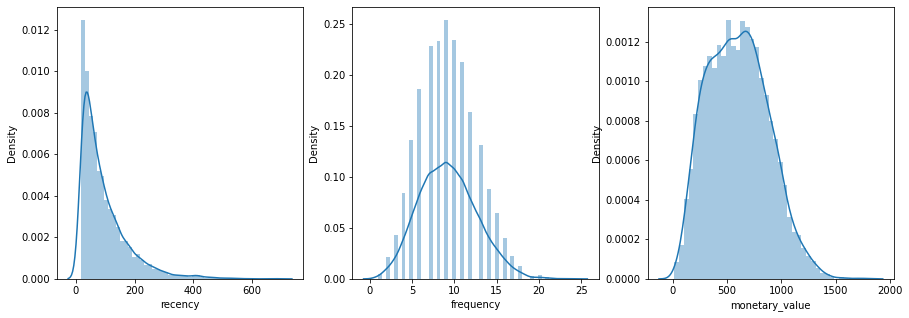

In [11]:
fig,axes=plt.subplots(1,3,figsize=(15,5))
for i,feature in enumerate(rfmTable.columns):
    sns.distplot(rfmTable[feature],ax=axes[i]);

Tiap feature memiliki distribusi yang berbeda, dimana pada recency banyak pelanggan yang melakukan transaksi terbarunya.
kalau berdasarkan frequencynya, kebanyakan pelanggan rata-rata transaksi 9 hingga 10 kali. Sedangkan uang yang mereka habiskan untuk bertransaksi bervariasi dari 0 sampai 2000 dolar, dan kebanyakan di sekitar 600-an dolar.

In [12]:
rfmTable.describe()

,recency,frequency,monetary_value
count,6884.000000,6884.000000,6884.000000
mean,96.024985,9.243608,601.268449
std,83.251016,3.379319,278.189593
min,16.000000,1.000000,14.000000
25%,38.000000,7.000000,379.000000
50%,69.000000,9.000000,591.000000
75%,127.000000,11.000000,796.000000
max,694.000000,24.000000,1791.000000


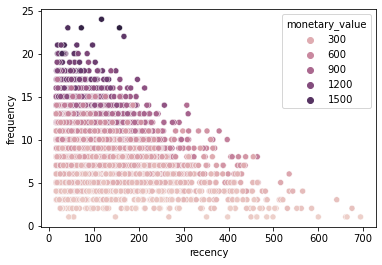

In [13]:
sns.scatterplot(data=rfmTable, x='recency', y='frequency', 
                hue='monetary_value');

belum terlalu jelas berapa clusternya, nanti kita pakai elbow saja

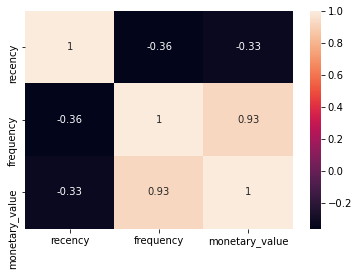

In [14]:
sns.heatmap(rfmTable.corr(),annot=True);

Berdasarkan korelasi antar feature, frequency memiliki hubungan yang sangat tinggi dengan monetary value hingga 93%. Hal ini menandakan semakin sering pelanggan bertransaksi, maka semakin besar pula nilai transaksi mereka kepada kita.

## Standarisasi

In [15]:
feats = ['recency', 'frequency','monetary_value']
X = rfmTable[feats].values


from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)
new_df = pd.DataFrame(data = X_std, columns = feats)

In [16]:
new_df

,recency,frequency,monetary_value
0,-0.228542,-0.959911,-0.874534
1,-0.540873,0.519785,0.624553
2,-0.576912,0.519785,0.728806
3,-0.829179,0.223846,0.588604
4,1.477267,-1.255850,-0.964407
...,...,...,...
6879,0.203916,-0.663971,-0.834989
6880,2.174005,-0.959911,-1.277166
6881,0.047751,-1.255850,-1.424558
6882,2.125954,-1.551789,-1.776861


## Modelling

## Elbow method untuk mengoptimalkan jumlah kluster dengan K-Means

Elbow method adalah metoda yang sering dipakai untuk menentukan jumlah cluster yang akan digunakan pada k-means clustering.

Clustering adalah meminimumkan jarak antara data point dan centroid, serta memaksimumkan jarak antara centroid yang dihitung menggunakan within-cluster sum of squares atau WCSS

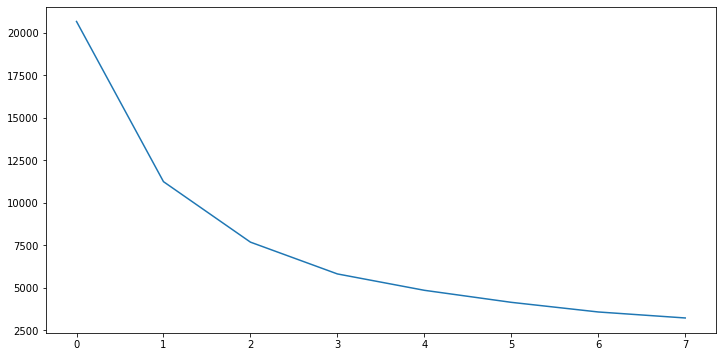

In [17]:
from sklearn.cluster import KMeans
inertia = []

for i in range(1, 9):
  kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
  kmeans.fit(new_df.values)
  inertia.append(kmeans.inertia_)

plt.figure(figsize=(12, 6))
plt.plot(inertia);

Oke... Kita bagi menjadi 3 cluster karena, setelah klaster ke 3, tidak ada perubahan yang significant. Bismillah

In [18]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(new_df.values)

KMeans(n_clusters=3, random_state=0)

In [19]:
print(kmeans.cluster_centers_)

[[-0.33704389  0.95833625  0.98103576]
 [ 1.97968017 -0.97787591 -0.91519274]
 [-0.26824471 -0.54756503 -0.58471895]]


In [20]:
# Menampilkan hasil kluster
print(kmeans.labels_)
# Menambahkan kolom "kluster" dalam data frame rfmtable
rfmTable["kluster"] = kmeans.labels_
rfmTable.head()

[2 0 0 ... 2 1 2]


,recency,frequency,monetary_value,kluster
customer_id,,,,
CS1112,77.0,6,358,2
CS1113,51.0,11,775,0
CS1114,48.0,11,804,0
CS1115,27.0,10,765,0
CS1116,219.0,5,333,1


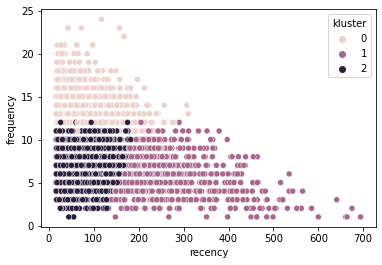

In [21]:
sns.scatterplot(data=rfmTable, x='recency', y='frequency', 
                hue='kluster');

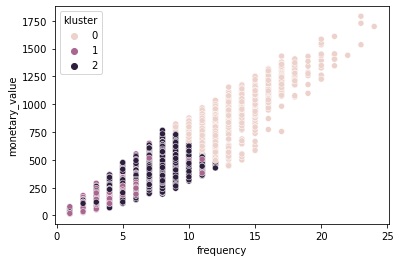

In [22]:
sns.scatterplot(data=rfmTable, x='frequency', y='monetary_value', 
                hue='kluster');

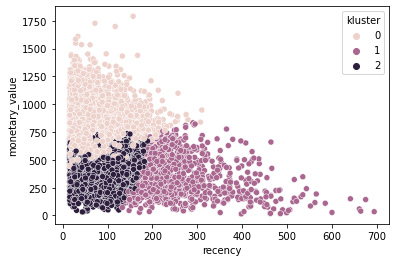

In [23]:
sns.scatterplot(data=rfmTable, x='recency', y='monetary_value', 
                hue='kluster');

In [24]:
summary=rfmTable.groupby('kluster').agg({
    'recency': ['mean','max','min'],
    'frequency': ['mean','max','min'],
    'monetary_value': ['mean','max','min']
}).reset_index()

In [25]:
summary.columns=['kluster','recency_mean','recency_max','recency_min','frequency_mean','frequency_max','frequency_min','monetary_mean','monetary_max','monetary_min']

In [26]:
summary

,kluster,recency_mean,recency_max,recency_min,frequency_mean,frequency_max,frequency_min,monetary_mean,monetary_max,monetary_min
0,0,67.953952,310.0,16.0,12.485859,24,9,874.457578,1791,447
1,1,260.592062,694.0,133.0,5.923925,12,1,345.501654,833,14
2,2,73.706741,193.0,16.0,7.401056,12,1,439.269338,766,32


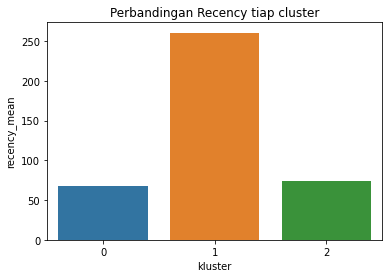

In [27]:
#fig,ax=plt.subplots()
sns.barplot(data=summary,x='kluster',y='recency_mean')
plt.title('Perbandingan Recency tiap cluster');

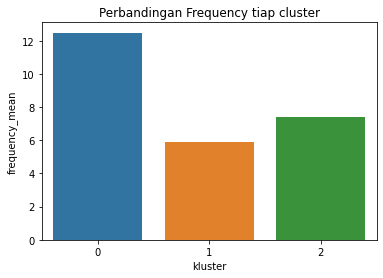

In [28]:
sns.barplot(data=summary,x='kluster',y='frequency_mean')
plt.title('Perbandingan Frequency tiap cluster');

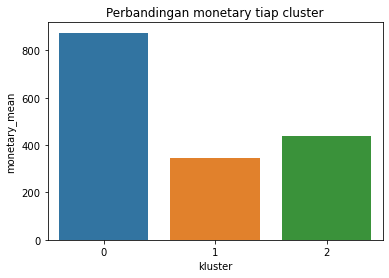

In [29]:
sns.barplot(data=summary,x='kluster',y='monetary_mean')
plt.title('Perbandingan monetary tiap cluster');

### Kesimpulan dan Insight

<b>Kluster 0</b> adalah pelanggan yang paling sering melakukan transaksi dan transaksi terbarunya dilakukan dalam waktu yang tidak jauh dari sekarang. Kluster 0 ini Paling banyak mengeluarkan uangnya untuk bertransaksi di market kita. Kluster ini merupakan target customer yang sangat potensial apabila kita meluncurkan produk baru. Pelanggan pada kluster ini bisa dikatakan pelanggan setia yang akan tetap berbelanja meskipun ada atau tidak ada nya promo.



<b>Kluster 1</b> adalah pelanggan yang sudah lama tidak bertransaksi di market kita. Saat bertransaksi di market kita mereka juga tidak terlalu sering melakukan transaksi. Sedangkan dari segi monetary value nya, mereka juga tidak terlalu banyak mengeluarkan uangnya di market kita. Kita perlu melakukan survey kepada kluster ini supaya kita bisa mengetahui alasan dibalik mereka churn. Kita harus memperbaiki kualitas product dan pelayanan untuk mencegah pelanggan churn terjadi lagi.

<b>Kluster 2</b> adalah pelanggan baru, yang dapat kita lihat bahwa dari rentang recency nya lebih kecil dari kluster 0. Untuk jumlah transaksinya masih belum terlalu banyak, tetapi sudah lebih baik dari kluster 1. Pada Kluster 2 ini, pelanggan belum banyak menghabiskan uangnya di market kita. Kita bisa memberikan promo kepada mereka untuk meningkatkan jumlah transaksi mereka.